
# HARQ допуск №2
## Кодирование/декодирование Хэмминга (7, 4, 3)

### Импорт библиотек

In [1]:
import timeit

In [2]:
from scipy.stats import norm
import numpy as np
import numpy.polynomial.polynomial as poly

In [3]:
import plotly
import plotly.graph_objects as go
plotly.offline.init_notebook_mode(connected=True)

### Функции моделирования канала

#### Инициализация порождающей, проверочной матриц, матрицы декодирования и матрицы исправления ошибки

In [4]:
G = np.array([
    [1, 1, 0, 1],
    [1, 0, 1, 1],
    [1, 0, 0, 0],
    [0, 1, 1, 1],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

H = np.array([
    [1, 0, 1, 0, 1, 0, 1],
    [0, 1, 1, 0, 0, 1, 1],
    [0, 0, 0, 1, 1, 1, 1]
])

R = np.array([
    [0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1]
])

# Создание матрицы с еденицами по диагонали с нулевым вектором в первой строке
correct_error_matrix = np.eye(8, 7, k=-1, dtype=int)

#### Инициализация функций кодирования/декодирования/проверки Хэмминга (7, 4, 3).

In [5]:
hamming_encode = lambda p: G @ p % 2
hamming_parity_check = lambda r: H @ r % 2
hamming_decode = lambda r: R @ r % 2

In [6]:
def modeling_step(index, snr, codewords_ham, g, n, hamming_codewords_all, pe):
    sigma = np.sqrt(1 / (2 * snr))
    nTests = nSent = 0
    nErrDecode = nErrDecode_soft = 0
    nErrBits = nErrBits_H = nErrBits_H_soft = 0

    hamming_codewords_all_bpsk = hamming_codewords_all * 2 - 1
    distance_vectors_func = lambda r: np.apply_along_axis(np.linalg.norm, -1, r - hamming_codewords_all_bpsk, ord=2)

    iterations = (40 ** np.log10(snr) * 3000).astype('int')
    for i in range(iterations):
        print('\r\t\tКоличество отправленных сообщений : {}/{}'.format(i + 1, iterations), end='')
        message_index = np.random.randint(0, codewords_ham.shape[0])

        while True:
            c = codewords_ham[message_index]                                # Hamming + BPSK
            c_AWGN = c + (sigma * np.random.randn(n[0], n[1]))              # AWGN
            c_x_AWGN = c_AWGN > 0                                           # unBPSK

            # Поиск и исправление ошибки
            S = np.apply_along_axis(hamming_parity_check, -1, c_x_AWGN)     # Поиск синдромов
            S = np.packbits(S, axis=-1, bitorder='little').reshape(-1)      # Преобразование в int
            c_x_corrected = c_x_AWGN ^ correct_error_matrix[S]              # Исправление ошибок по индексам
            c_x_corrected_decode = np.apply_along_axis(hamming_decode, -1, c_x_corrected).reshape(-1)

            # Поиск векторов с минимальным расстоянием
            distance_vectors = np.apply_along_axis(distance_vectors_func, -1, c_AWGN)
            indexes_vectors_with_min_distance = np.apply_along_axis(np.argmin, -1, distance_vectors)
            vectors_with_min_distance = hamming_codewords_all[indexes_vectors_with_min_distance]
            vectors_with_min_distance_decode = np.apply_along_axis(hamming_decode, -1, vectors_with_min_distance)
            c_x_corrected_decode_soft = vectors_with_min_distance_decode.reshape(-1)

            v = ((c > 0) ^ c_x_corrected).sum()
            s = np.mod(poly.polydiv(c_x_corrected_decode, g), 2)[1].max() == 1       # unCRC

            v_soft = ((c > 0) ^ vectors_with_min_distance).sum()
            s_soft = np.mod(poly.polydiv(c_x_corrected_decode_soft, g), 2)[1].max() == 1  # unCRC

            nTests += 1
            nErrBits += ((c > 0) ^ c_x_AWGN).sum()
            nErrBits_H += v
            nErrBits_H_soft += v_soft

            if not s_soft and v_soft > 0:
                nErrDecode_soft += 1

            if not s:
                if v > 0:
                    nErrDecode += 1
                nSent += 1
                break

    n_test_mult_num_bits_in_message = nTests * np.prod(n)  # количество тестов * количество бит в сообщении
    pe['Ped'][index] = nErrDecode / nTests
    pe['Ped_soft'][index] = nErrDecode_soft / nTests
    pe['Pe_bit'][index] = nErrBits / n_test_mult_num_bits_in_message
    pe['Pe_bit_after_Hamming'][index] = nErrBits_H / n_test_mult_num_bits_in_message
    pe['Pe_bit_after_Hamming_soft'][index] = nErrBits_H_soft / n_test_mult_num_bits_in_message
    pe['T'][index] = k * nSent / n_test_mult_num_bits_in_message

    return pe

In [7]:
def channel_modeling(snr_db, codewords_bits, codewords_ham, hamming_codewords, g):
    r = g.size - 1
    n = codewords_ham.shape[1:3]
    w = np.sum(codewords_bits[1:], axis=1)
    d = int(np.min(w))

    SNR = 10 ** (snr_db / 10)
    Pe = dict(
        Ped=np.zeros(snr_db.size),
        Ped_soft=np.zeros(snr_db.size),
        Ped_theor=np.zeros(snr_db.size),
        Ped_theor_up=np.ones(SNR.size) * (1 / 2 ** r),

        Pe_bit=np.zeros(snr_db.size),
        Pe_bit_theor=norm.sf(np.sqrt(2 * SNR)),
        Pe_bit_after_Hamming=np.zeros(snr_db.size),
        Pe_bit_after_Hamming_soft=np.zeros(snr_db.size),

        T=np.zeros(snr_db.size)
    )

    for i in range(SNR.size):
        start_time = timeit.default_timer()
        print('[{}/{}]\tSNRdB = {}\t'.format(i + 1, SNR.size, snr_db[i]))
        Pe = modeling_step(i, SNR[i], codewords_ham, g, n, hamming_codewords, Pe)
        print('\n\t\tВремя выполнения : {:.1f}с'.format(timeit.default_timer() - start_time))

        for j in range(d, np.prod(n) + 1):
            Pe['Ped_theor'][i] += \
                np.sum(w == j) * (Pe['Pe_bit_theor'][i] ** j) * ((1 - Pe['Pe_bit_theor'][i]) ** (np.prod(n) - j))

    return Pe

#### Инициализация порождающего многочлена и количества сообщений

In [8]:
g_x = np.flip(np.array([1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1]))  # [3, 2, 1] даст 1 + 2*x + 3*x**2.
k = 8  # 2^k сообщений

#### Загрузка заранее созданных таблиц

In [9]:
messages = np.load('./../Tables/messages_2^{}.npy'.format(k)).astype('int')
codewords = np.load('./../Tables/codewords_bits_2^{}.npy'.format(k)).astype('int')

#### Изменнение размерности сообщений и кодирование по Хэммингу. Создании всех кодовых слов Хэмминга

In [10]:
codewords_hamming = codewords.reshape((codewords.shape[0], codewords.shape[1] // 4, 4))  # (256, 24) -> (256, 6, 4)
codewords_hamming = np.apply_along_axis(hamming_encode, -1, codewords_hamming)           # (256, 6, 4) -> (256, 6, 7)

codewords_for_channel = codewords_hamming * 2 - 1

all_hamming_codewords = np.apply_along_axis(hamming_encode, -1, messages[:16, :4])

#### Инициализация масива уровней сигнал/шум

In [11]:
SNRdB = np.arange(-10, 11, 2)

#### Моделирование канала

In [12]:
dict_Pe = channel_modeling(SNRdB, codewords, codewords_for_channel, all_hamming_codewords, g_x)

[1/11]	SNRdB = -10	
		Количество отправленных сообщений : 160/160
		Время выполнения : 804.4с
[2/11]	SNRdB = -8	
		Количество отправленных сообщений : 401/401
		Время выполнения : 422.2с
[3/11]	SNRdB = -6	
		Количество отправленных сообщений : 1009/1009
		Время выполнения : 200.5с
[4/11]	SNRdB = -4	
		Количество отправленных сообщений : 2535/2535
		Время выполнения : 104.7с
[5/11]	SNRdB = -2	
		Количество отправленных сообщений : 6369/6369
		Время выполнения : 76.1с
[6/11]	SNRdB = 0	
		Количество отправленных сообщений : 16000/16000
		Время выполнения : 78.0с
[7/11]	SNRdB = 2	
		Количество отправленных сообщений : 40190/40190
		Время выполнения : 129.1с
[8/11]	SNRdB = 4	
		Количество отправленных сообщений : 100953/100953
		Время выполнения : 289.9с
[9/11]	SNRdB = 6	
		Количество отправленных сообщений : 253582/253582
		Время выполнения : 718.1с
[10/11]	SNRdB = 8	
		Количество отправленных сообщений : 636971/636971
		Время выполнения : 1796.2с
[11/11]	SNRdB = 10	
		Количество отправлен

#### График вероятности ошибки декодирования

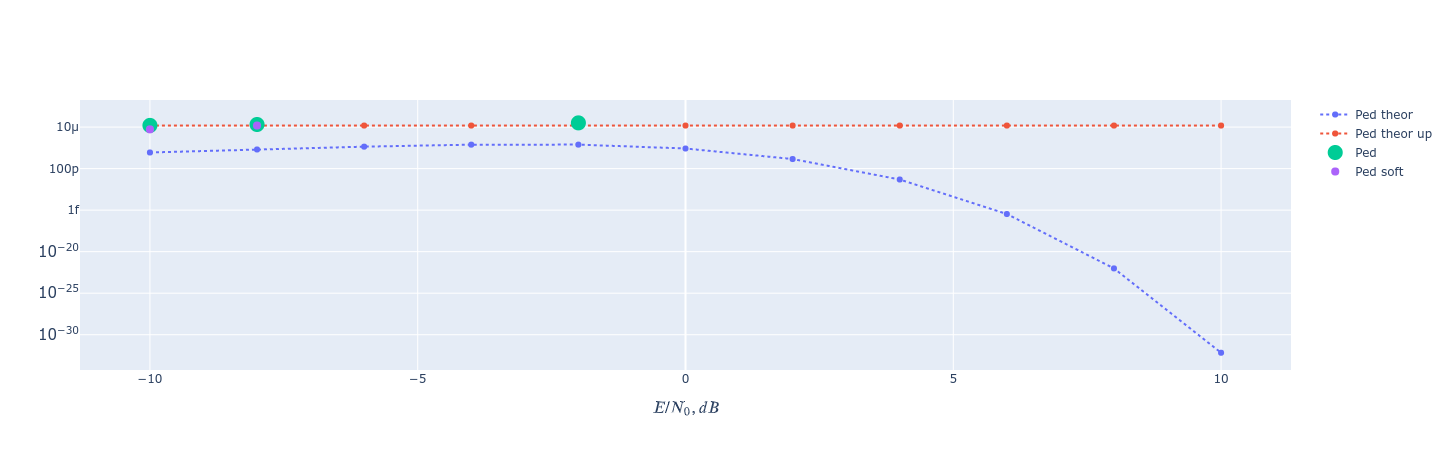

In [13]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=SNRdB, y=dict_Pe['Ped_theor'], line=dict(dash='dot'), name='Ped theor'))
fig.add_trace(go.Scatter(x=SNRdB, y=dict_Pe['Ped_theor_up'], line=dict(dash='dot'), name='Ped theor up'))
fig.add_trace(go.Scatter(x=SNRdB, y=dict_Pe['Ped'], mode='markers', marker=dict(size=15), name='Ped'))
fig.add_trace(go.Scatter(x=SNRdB, y=dict_Pe['Ped_soft'], mode='markers', marker=dict(size=8), name='Ped soft'))
fig.update_layout(xaxis_title='$E/N_0, dB$', yaxis_type="log")
fig.show()

#### График вероятности ошибки на бит

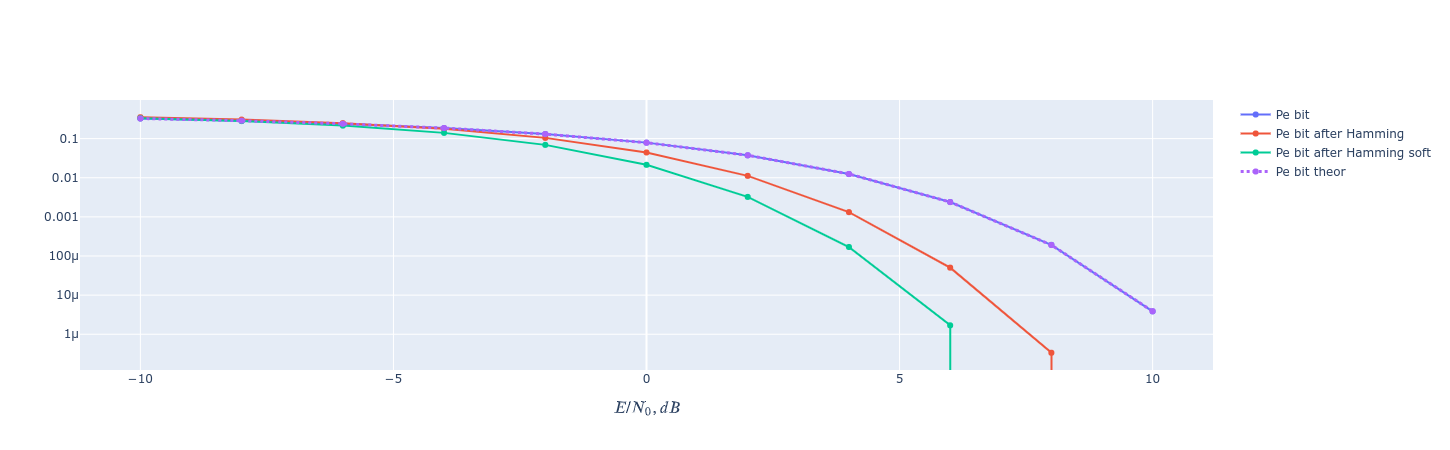

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=SNRdB, y=dict_Pe['Pe_bit'], mode='lines+markers', name='Pe bit'))
fig.add_trace(go.Scatter(x=SNRdB, y=dict_Pe['Pe_bit_after_Hamming'], mode='lines+markers', name='Pe bit after Hamming'))
fig.add_trace(go.Scatter(x=SNRdB, y=dict_Pe['Pe_bit_after_Hamming_soft'], mode='lines+markers', name='Pe bit after Hamming soft'))
fig.add_trace(go.Scatter(x=SNRdB, y=dict_Pe['Pe_bit_theor'], line=dict(dash='dot', width=3), name='Pe bit theor'))
fig.update_layout(xaxis_title='$E/N_0, dB$', yaxis_type="log")
fig.show()

#### График пропускной способности канала

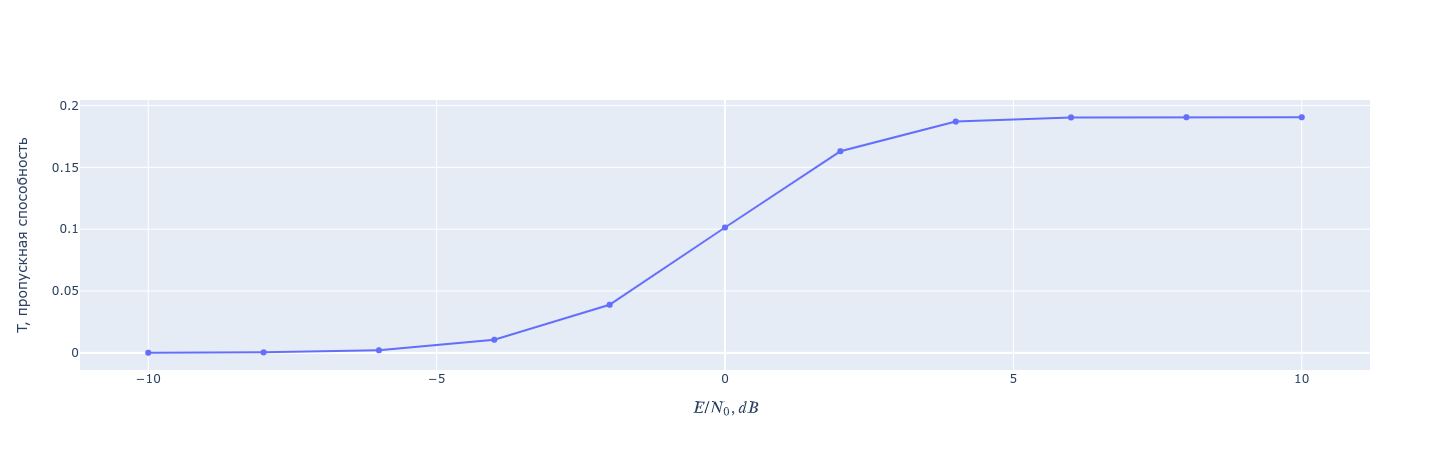

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=SNRdB, y=dict_Pe['T'], mode='lines+markers', name='T'))
fig.update_layout(xaxis_title='$E/N_0, dB$', yaxis_title='T, пропускная способность')
fig.show()